In [1]:
# Install igraph
# %pip install numpy matplotlib --quiet

In [2]:
import igraph as ig
import numpy as np
import random
ig.config["plotting.backend"] = "matplotlib"

In [3]:
%run -i functions.ipynb

# Significance of Community Structure
There are multiple methods that we can use to test if a network has a significant community
structure. These methods are complementary and sometimes we need to use more than one
to gain confidence in our result.

## Method 1: Testing network structure with modularity 

__Idea__: Compare to a null model.
- Find communities in our network and measure the modularity.
- Randomize the network, by rewireing, while keeping some property (typically the degrees) fixed. Detect communities again. Did the modularity drop? If yes, then the original network has a significantly high modularity score.

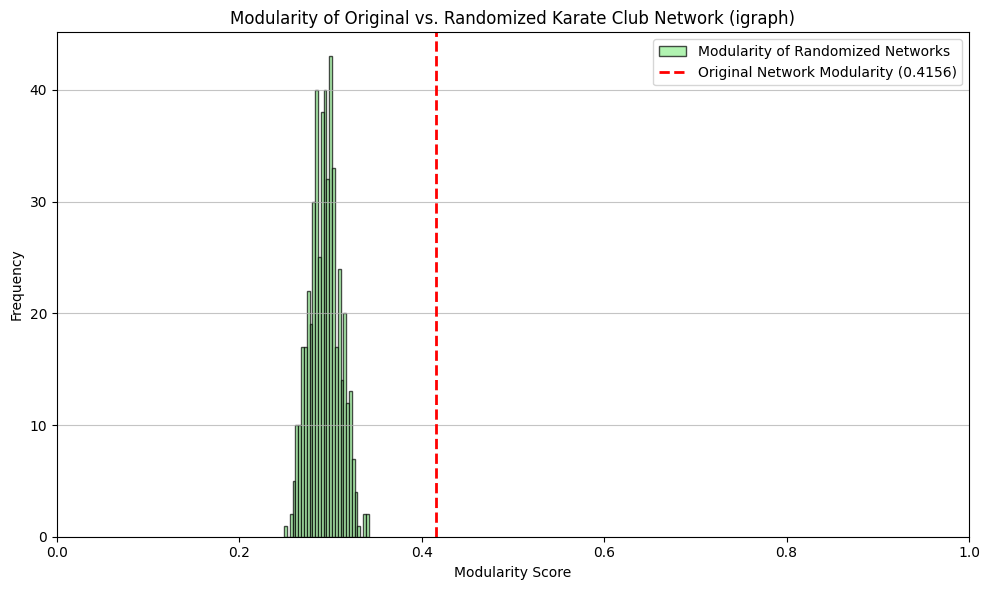

In [4]:
karate_club = ig.Graph.Famous("Zachary")

test_community_structure(karate_club, graph_name="Karate Club Network")

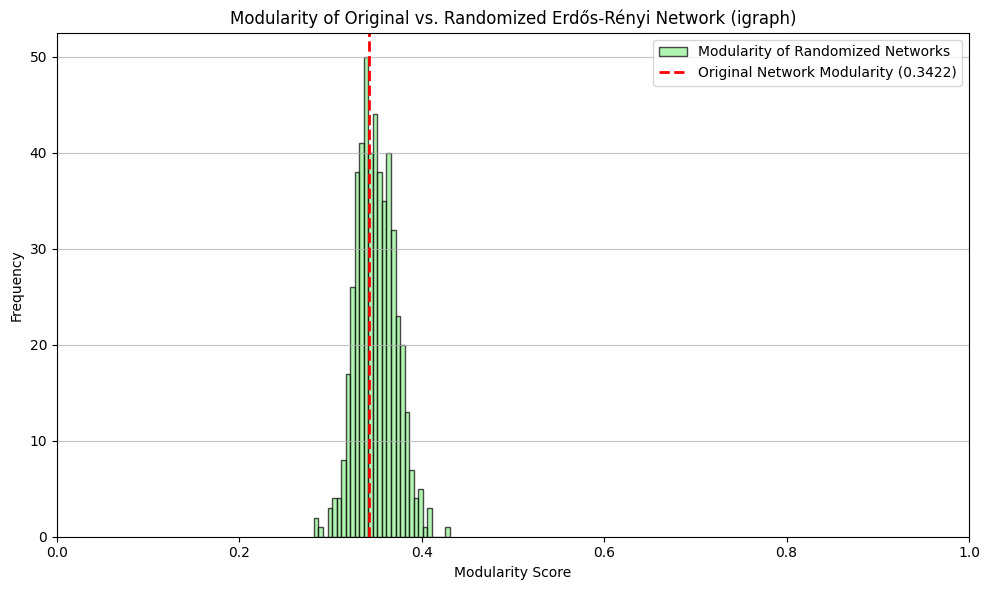

In [5]:
num_nodes = karate_club.vcount()
num_edges = karate_club.ecount()

er_graph = ig.Graph.Erdos_Renyi(n=num_nodes, m=num_edges)

er_modularity_orig = get_modularity_on_clustering(karate_club)

test_community_structure(er_graph, graph_name="Erdős-Rényi Network")

## Method 2: Testing network structure with NMI values
__Idea__: Do we get consistent results across different tries?

Let’s use a stochastic community detection algorithm like Leiden method, run it 100 times to obtain 100 different groupings/partitionings, and compare the partitionings. Does the method tend to return roughly the same result? To answer this question, we will use a measure called “normalized mutual information” to compare partitionings to each other, pairwise. A value of 1 means that the two partitions are identical, a high value (close to 1) means that they are similar, a low value means that they are dissimilar.

### Pairwise comparisons


Running Louvain community detection 500 times and calculating NMI...
  Processed 50/500 runs.
  Processed 100/500 runs.
  Processed 150/500 runs.
  Processed 200/500 runs.
  Processed 250/500 runs.
  Processed 300/500 runs.
  Processed 350/500 runs.
  Processed 400/500 runs.
  Processed 450/500 runs.
  Processed 500/500 runs.


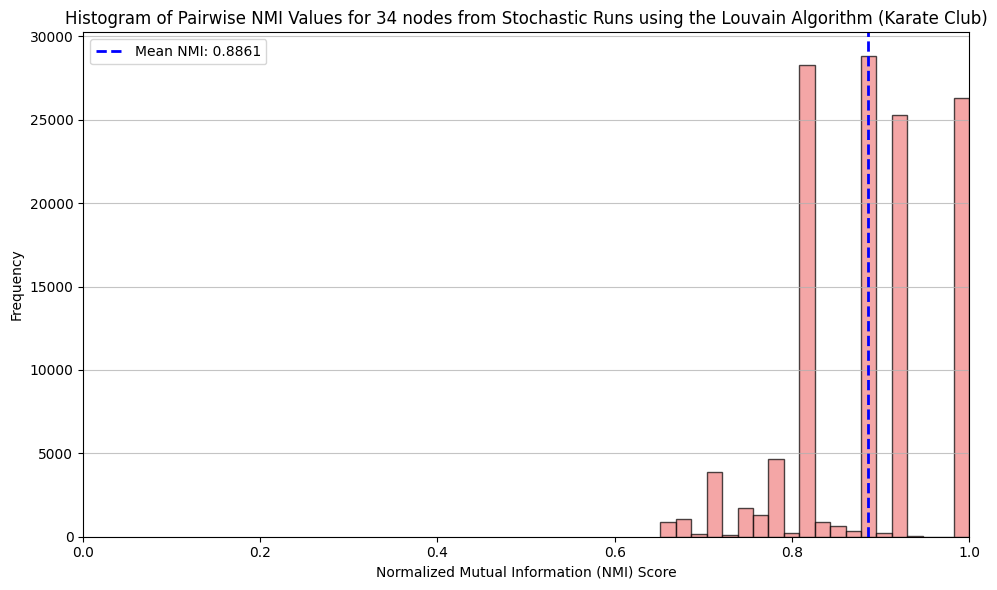

In [6]:
title = f'Histogram of Pairwise NMI Values for {karate_club.vcount()} nodes from Stochastic Runs using the Louvain Algorithm (Karate Club)'
all_partitions = run_stochastic_community_detection(karate_club, None, 500, community_detection_method="multilevel", return_partitions=True)
pairwise_nmi_values = calculate_pairwise_nmi(all_partitions)

plot_nmi_histogram(karate_club, pairwise_nmi_values, title)


Running Louvain community detection 500 times and calculating NMI...
  Processed 50/500 runs.
  Processed 100/500 runs.
  Processed 150/500 runs.
  Processed 200/500 runs.
  Processed 250/500 runs.
  Processed 300/500 runs.
  Processed 350/500 runs.
  Processed 400/500 runs.
  Processed 450/500 runs.
  Processed 500/500 runs.


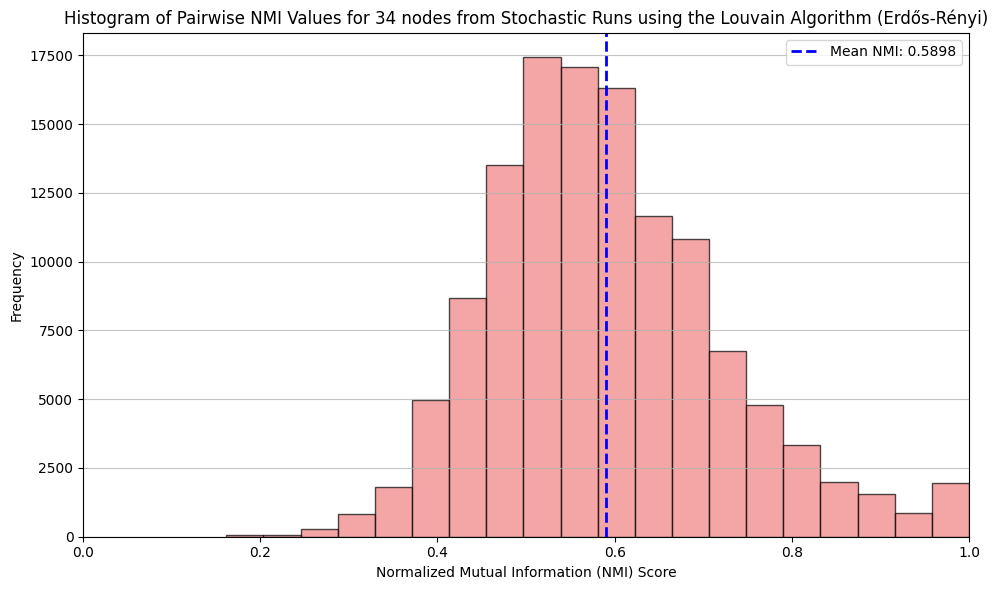

In [7]:
title = f'Histogram of Pairwise NMI Values for {er_graph.vcount()} nodes from Stochastic Runs using the Louvain Algorithm (Erdős-Rényi)'
all_partitions = run_stochastic_community_detection(er_graph, None, 500, community_detection_method="multilevel", return_partitions=True)
pairwise_nmi_values = calculate_pairwise_nmi(all_partitions)

plot_nmi_histogram(er_graph, pairwise_nmi_values, title)


Running Louvain community detection 500 times and calculating NMI...
  Processed 50/500 runs.
  Processed 100/500 runs.
  Processed 150/500 runs.
  Processed 200/500 runs.
  Processed 250/500 runs.
  Processed 300/500 runs.
  Processed 350/500 runs.
  Processed 400/500 runs.
  Processed 450/500 runs.
  Processed 500/500 runs.


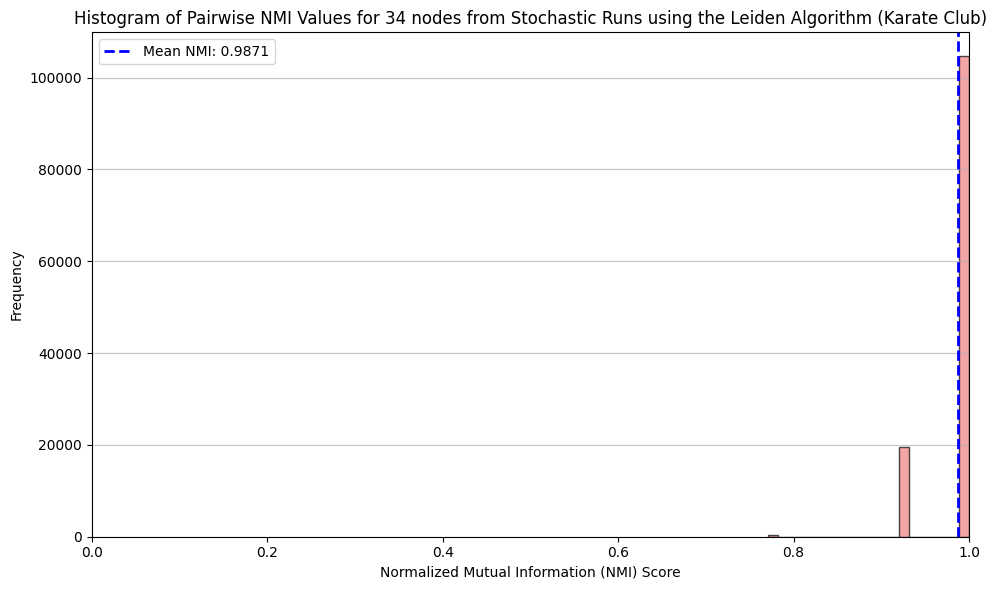

In [8]:
num_runs = 500
params = {
    "objective_function": "modularity",
    "resolution": np.ones(num_runs),
}
title = f'Histogram of Pairwise NMI Values for {karate_club.vcount()} nodes from Stochastic Runs using the Leiden Algorithm (Karate Club)'
all_partitions = run_stochastic_community_detection(karate_club, None, num_runs, community_detection_method="leiden", 
                                                    return_partitions=True, params=params)
pairwise_nmi_values = calculate_pairwise_nmi(all_partitions)

plot_nmi_histogram(karate_club, pairwise_nmi_values, title)


Running Louvain community detection 500 times and calculating NMI...
  Processed 50/500 runs.
  Processed 100/500 runs.
  Processed 150/500 runs.
  Processed 200/500 runs.
  Processed 250/500 runs.
  Processed 300/500 runs.
  Processed 350/500 runs.
  Processed 400/500 runs.
  Processed 450/500 runs.
  Processed 500/500 runs.


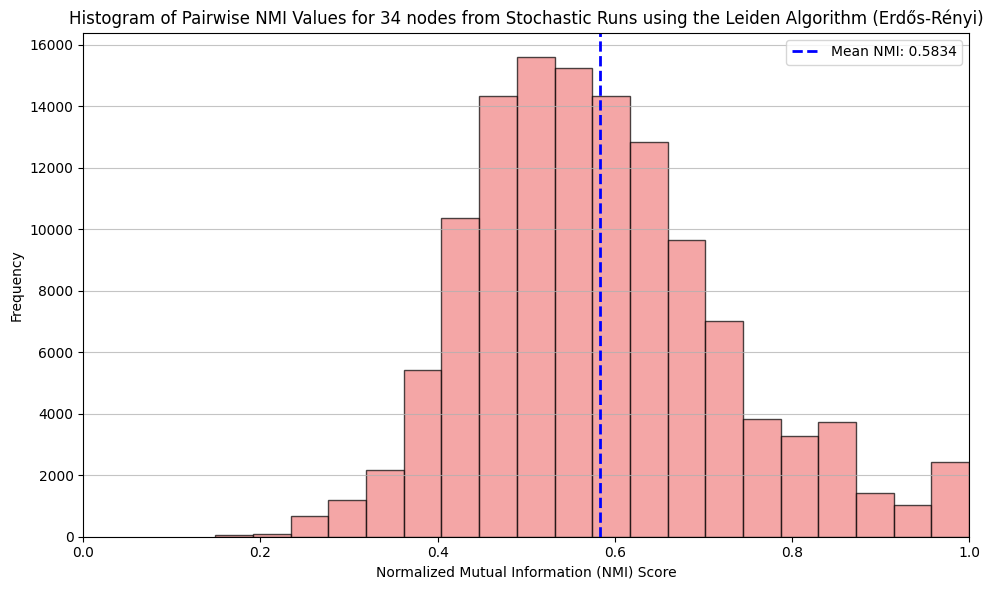

In [9]:
num_runs = 500
params = {
    "objective_function": "modularity",
    "resolution": np.ones(num_runs),
}
title = f'Histogram of Pairwise NMI Values for {er_graph.vcount()} nodes from Stochastic Runs using the Leiden Algorithm (Erdős-Rényi)'
all_partitions = run_stochastic_community_detection(er_graph, None, num_runs, community_detection_method="leiden", 
                                                    return_partitions=True, params=params)
pairwise_nmi_values = calculate_pairwise_nmi(all_partitions)

plot_nmi_histogram(er_graph, pairwise_nmi_values, title)


Running Louvain community detection 500 times and calculating NMI...
  Processed 50/500 runs.
  Processed 100/500 runs.
  Processed 150/500 runs.
  Processed 200/500 runs.
  Processed 250/500 runs.
  Processed 300/500 runs.
  Processed 350/500 runs.
  Processed 400/500 runs.
  Processed 450/500 runs.
  Processed 500/500 runs.


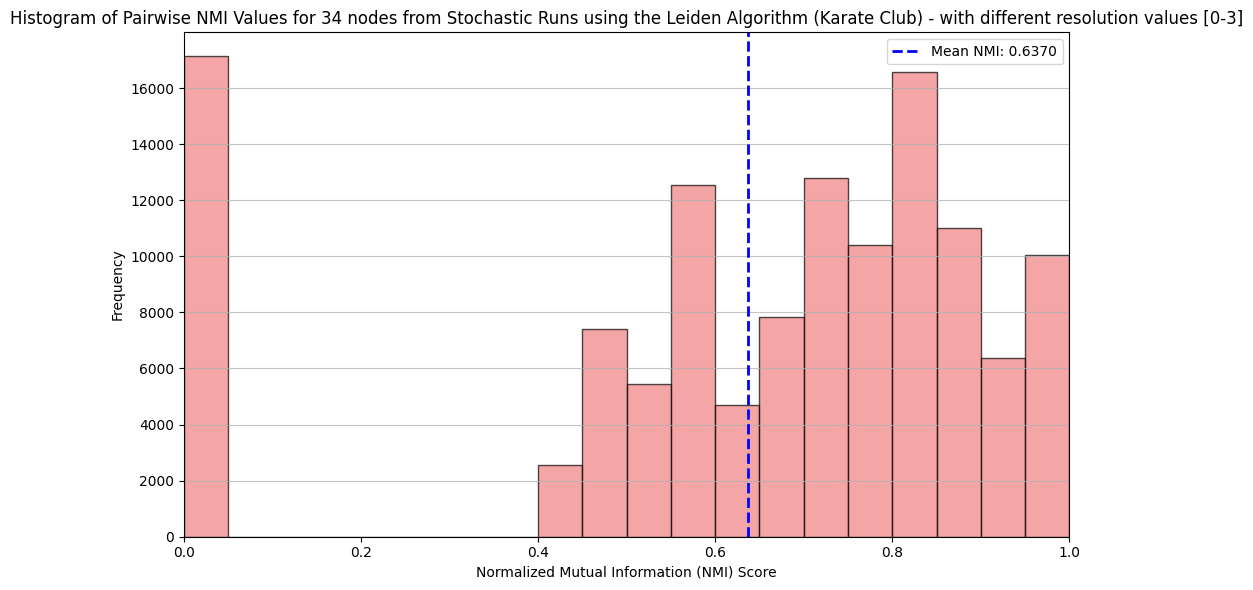

In [10]:
params = {
    "objective_function": "modularity",
    "resolution": [random.uniform(0., 3.) for _ in range(num_runs)]
}
title = f'Histogram of Pairwise NMI Values for {karate_club.vcount()} nodes from Stochastic Runs using the Leiden Algorithm (Karate Club) - with different resolution values [0-3]'
all_partitions = run_stochastic_community_detection(karate_club, None, num_runs, community_detection_method="leiden", 
                                                    return_partitions=True, params=params)
pairwise_nmi_values = calculate_pairwise_nmi(all_partitions)

plot_nmi_histogram(karate_club, pairwise_nmi_values, title)

## Testing Significance of Community Structure on a Grid Graph

Clustering graph with 100 vertices and 180 edges using Leiden algorithm...


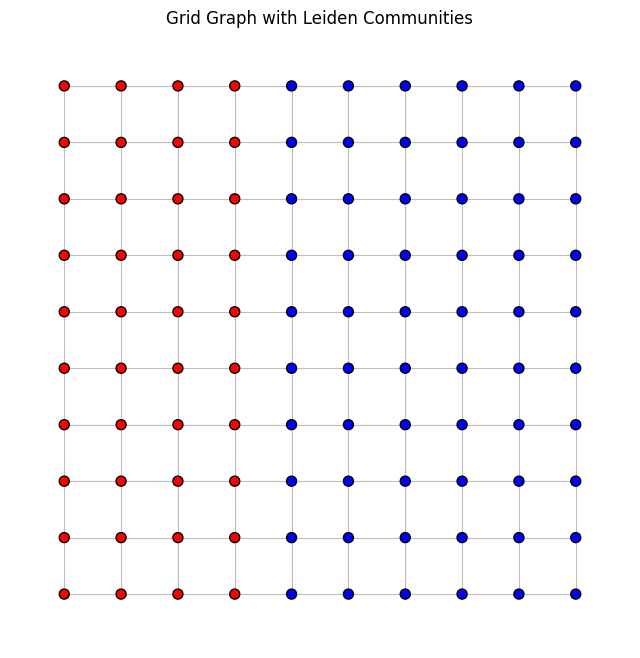

In [14]:
grid_cols = 10
grid_graph = create_grid_graph(grid_cols, grid_cols, circular=False)
random.seed(13)
partition, resolution = cluster_and_plot_leiden_on_grid(grid_graph, grid_cols, title="Grid Graph with Leiden Communities", plot_size=(8, 8))

Clustering graph with 100 vertices and 180 edges using Leiden algorithm...


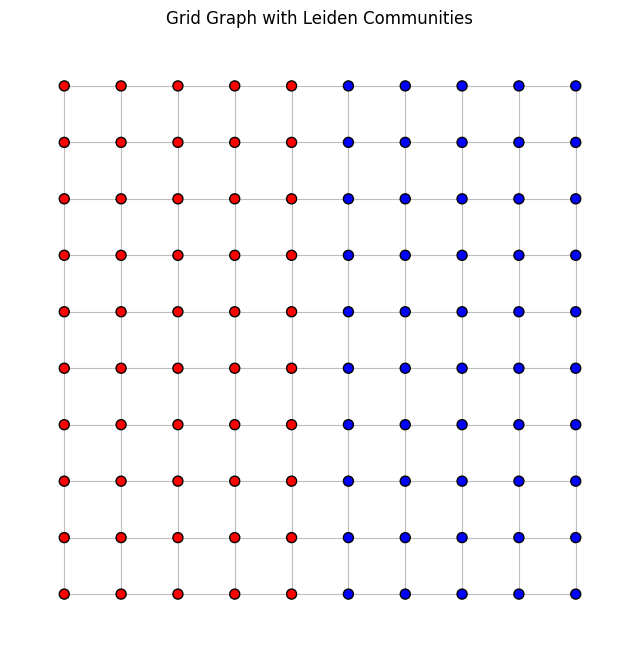

In [18]:
random.seed(44)
partition, resolution = cluster_and_plot_leiden_on_grid(grid_graph, grid_cols, title="Grid Graph with Leiden Communities", plot_size=(8, 8))

Clustering graph with 100 vertices and 180 edges using Leiden algorithm...


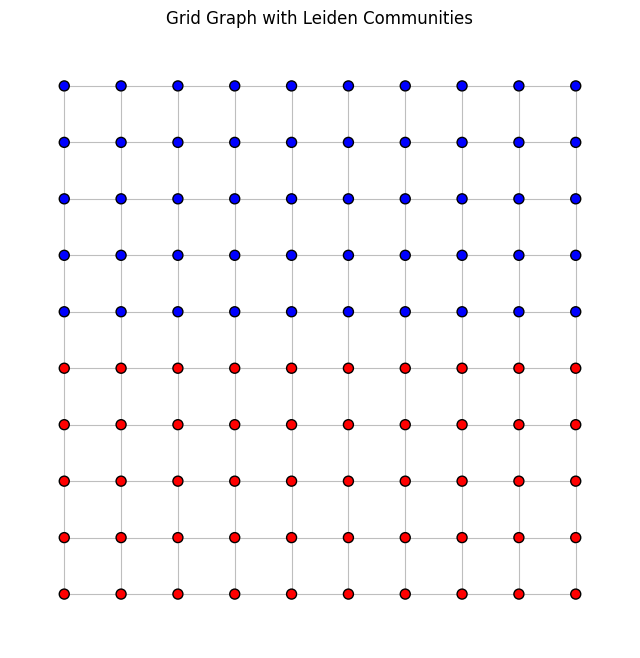

In [21]:
random.seed(60)
partition, resolution = cluster_and_plot_leiden_on_grid(grid_graph, grid_cols, title="Grid Graph with Leiden Communities", plot_size=(8, 8))

_Note:_ The previous plots show that the clustering can produce different outputs. However, one is not necessarily better than the other; their quality is essentially equivalent.

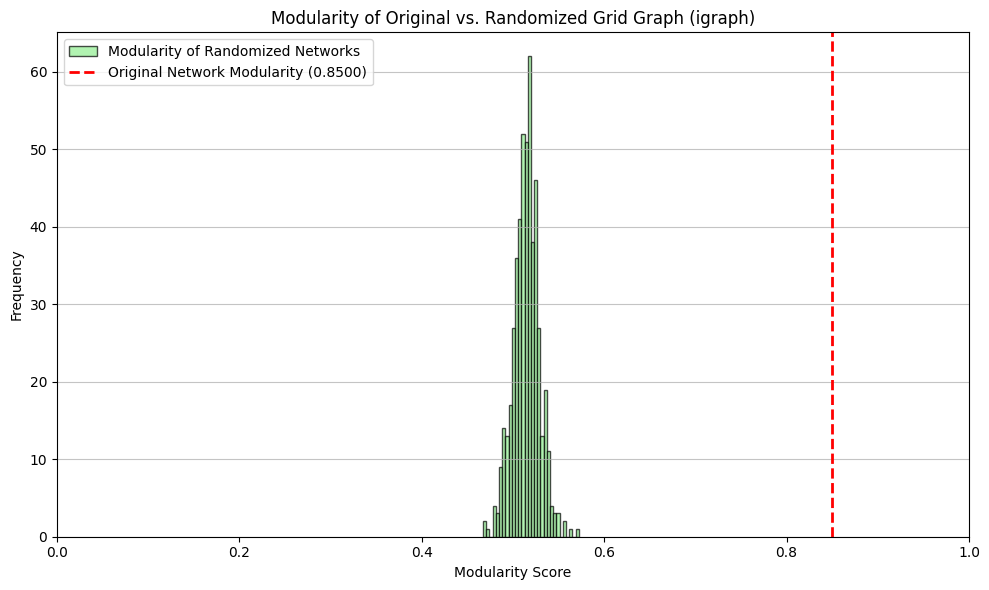

In [12]:
params = {
    "objective_function": "modularity",
    "resolution": 0.15,
}
test_community_structure(grid_graph, graph_name="Grid Graph", community_detection_method="leiden", params=params)

The modularity is significantly higher in both grids than in their randomized versions. This is because after randomization, it is no longer possible to find a grouping in which nodes mostly connect to other nodes within the same group. Yet grids/lattices are homogeneous, so we can’t say that they have a community structure. This is an example of a situation where only _Method 2_ could warn us that the community structure we find may not be valid.


Running Louvain community detection 500 times and calculating NMI...
  Processed 50/500 runs.
  Processed 100/500 runs.
  Processed 150/500 runs.
  Processed 200/500 runs.
  Processed 250/500 runs.
  Processed 300/500 runs.
  Processed 350/500 runs.
  Processed 400/500 runs.
  Processed 450/500 runs.
  Processed 500/500 runs.


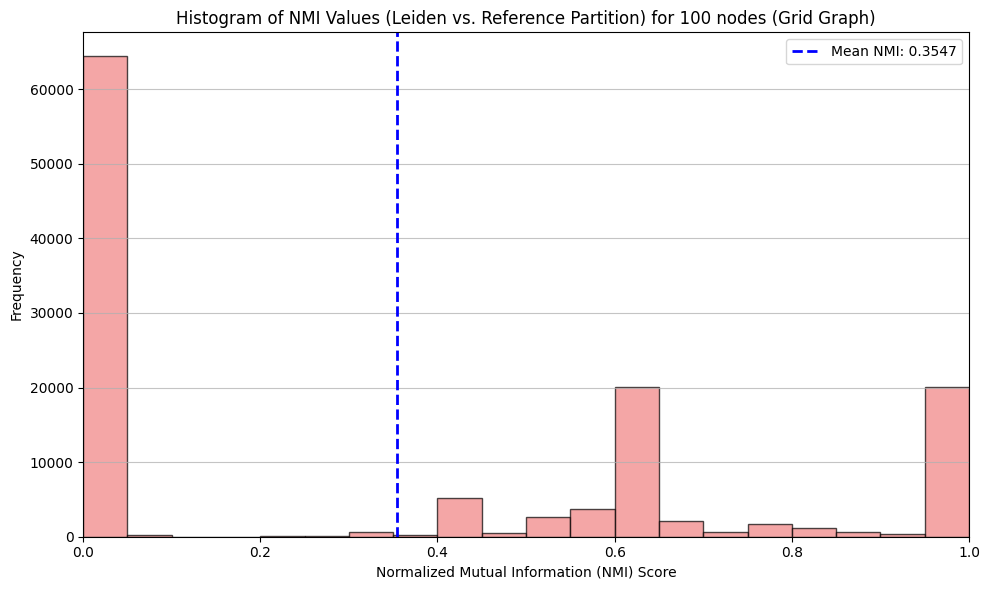

In [13]:
num_runs = 500
params = {
    "objective_function": "modularity",
    "resolution": [resolution for _ in range(num_runs)],
}
title = f'Histogram of NMI Values (Leiden vs. Reference Partition) for {grid_graph.vcount()} nodes (Grid Graph)'
all_partitions = run_stochastic_community_detection(grid_graph, None, num_runs, community_detection_method="leiden", 
                                                    return_partitions=True, params=params)
pairwise_nmi_values = calculate_pairwise_nmi(all_partitions)

plot_nmi_histogram(er_graph, pairwise_nmi_values, title)